# Processes

## Introduction

In simulation and modelling we encounter a wide range of stochastic processes. But most fall into a few common categories: Ito processes, martingales, Markov processes, Gaussian processes, etc. We attempt to take this into account in our treatment of stochastic processes in thalesians.tsa, where we represent different categories of stochastic processes with distinct abstract data types.

Before we proceed, we need to enable Matplotlib to inline its graphs in this Jupyter notebook...

In [1]:
%matplotlib inline

...and import some Python modules:

In [2]:
import os, sys
sys.path.append(os.path.abspath('../../main/python'))
import numpy as np
import matplotlib.pyplot as plt
import thalesians.tsa.numpyutils as npu
import thalesians.tsa.processes as proc
import thalesians.tsa.random as rnd
import thalesians.tsa.simulation as sim

## Ito processes

An **Ito process** is defined to be an adapted stochastic process that can be expressed as the sum of an integral with respect to a Wiener process and an integral with respect to time,
$$X_t = X_0 + \int_0^t \mu_s \, ds + \int_0^t \sigma_s \, dW_s,$$
or, in differential form,
$$dX_s = \mu_s \, ds + \sigma_s \, dW_s,$$
where $W$ is a Wiener process, $\sigma$ a predictable $W$-integrable process, $\mu$ predictable and Lebesgue-integrable. The integrability conditions can be expressed as
$$\int_0^t (\sigma_s^2 + |\mu_s|) \, ds < \infty.$$

$\mu$ and $\sigma$ are allowed to depend both on the time and current state, so we can write
$$X_t = X_0 + \int_0^t \mu(s, X_s) \, ds + \int_0^t \sigma(s, X_s) \, dW_s.$$

The function $\mu$ is referred to as **drift**, the function $\sigma$ as **diffusion**. The `ItoProcess` can thus be specified by providing these two functions:

In [3]:
X = proc.ItoProcess(drift=lambda t, x: -x, diffusion=lambda t, x: .25)

It can then be approximated with a stochastic time discrete approximation, such as the **Euler-Maruyama** strong Taylor approximation scheme:

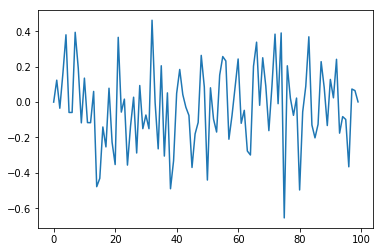

In [4]:
rnd.random_state(np.random.RandomState(seed=42), force=True);
ts = []; xs = []
for t, x in sim.EulerMaruyama(process=X, times=sim.xtimes(0., 100.)):
    ts.append(t); xs.append(x.flatten())
plt.plot(ts, xs);

Since in this particular case the diffusion coefficient is constant, we could have defined X as

In [5]:
X = proc.ItoProcess(drift=lambda t, x: -x, diffusion=.25)

## Solved Ito processes
In case the stochastic differential equation
$$X_t = X_0 + \int_0^t \mu(s, X_s) \, ds + \int_0^t \sigma(s, X_s) \, dW_s$$
has a solution, it may be possible to compute the above integrals analytically. Although the rigorous theory of SDE requires one to specify what exactly one means by a "solution", we shall reserve the term **solved Ito process** for those Ito processes where these integrals can be computed analytically. Such processes should inherit from the `SolvedItoProcess` class and override its abstract method

In [6]:
def propagate(self, time0, value0, time, variate=None, state0=None, random_state=None):
    raise NotImplementedError()

Given the time `time0` and the process's value at that time, `value0`, and (if the process is stateful) the process's state, `state0`, at `time0`, as well as the random variate `variate` corresponding to the actual increment in the driving Brownian motion $W$, the `propagate` method will return the value of the process at `time`, `time >= time0`. If `propagate` is implemented, there is no need to resort to approximate schemes, such as the Euler-Maruyama scheme demonstrated above.

In fact, the Ito process in our example above happens to be an Ornstein-Uhlenbeck process, whose solution is well known:

In [7]:
X = proc.OrnsteinUhlenbeckProcess(transition=1, vol=.25)

We make sure that we generate it with the same random seed...

In [8]:
rnd.random_state(np.random.RandomState(seed=42), force=True);

...and verify that the graph is unchanged when we apply `EulerMaruyama` to this process, now instantiated as an `OrnsteinUhlenbeckProcess`, rather than an `ItoProcess`:

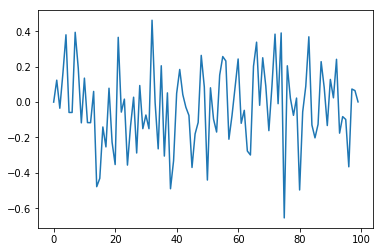

In [9]:
ts = []; xs = []
for t, x in sim.EulerMaruyama(process=X, times=sim.xtimes(0., 100.)):
    ts.append(t); xs.append(x.flatten())
plt.plot(ts, xs);

Instead of looping explicitly, we could have used the method `run`:

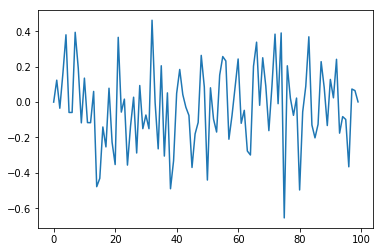

In [10]:
rnd.random_state(np.random.RandomState(seed=42), force=True)
em = sim.EulerMaruyama(process=X, times=sim.xtimes(0., 100.))
df = sim.run(em)
plt.plot(df);

Now, since

In [11]:
isinstance(X, proc.SolvedItoProcess)

True

we don't need to apply Euler-Maruyama to produce a trajectory of this process and can use the `propagate` method instead:

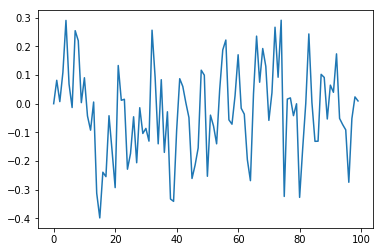

In [12]:
rnd.random_state(np.random.RandomState(seed=42), force=True);
x = 0.
ts = [0.]; xs = [x]
for t, v in zip(sim.xtimes(1., 100., 1.), rnd.multivariate_normals(ndim=1)):
    x = X.propagate(ts[-1], x, t, v)
    ts.append(t); xs.append(x.flatten())
plt.plot(ts, xs);

## Markov processes
Informally, a **Markov process** models the motion of a particle that moves around in a measurable space in a memoryless way. Such processes are extremely important and merit their own theory. The Wiener process and the Ornstein-Uhlenbeck process illustrated above are special cases. There also deserve special treatment in filtering theory &mdash; both Kalman and particle filtering.

In thalesians.tsa, Markov processes inherit from the abstract class `MarkovProcess`. Thus they provide the method

In [13]:
def propagate_distr(self, time0, distr0, time):
    pass

This method represents the transition kernel of the Markov process: given the marginal distribution at `time0`, `distr0`, and `time >= time0`, the method returns the marginal distribution at `time`.

## Solved Ito Markov processes
Processes that are both "solved Ito" (and therefore children of `SolvedItoProcess`) and Markov (and therefore children of `MarkovProcess`) should inherit from `SolvedItoMarkovProcess`. By default, their `propagate` is implemented in terms of their `propagate_distr` using the Dirac delta:

In [14]:
def propagate(self, time0, value0, time, variate=None, state0=None, random_state=None):
    if self.noisedim != self.processdim:
        raise NotImplementedError('Cannot utilise the propagate_distr of the Markov process in propagate if noisedim != processdim; provide a custom implementation')
    if time == time0: return npu.tondim2(value0, ndim1tocol=True, copy=True)
    value0 = npu.tondim2(value0, ndim1tocol=True, copy=False)
    variate = npu.tondim2(variate, ndim1tocol=True, copy=False)
    distr = self.propagate_distr(time, time0, distrs.NormalDistr.creatediracdelta(value0))
    return distr.mean + np.dot(np.linalg.cholesky(distr.cov), variate)

## Gaussian and Gauss-Markov processes
**Gaussian processes** play an important role in mathematical finance, machine learning, and in stochastic filtering, where the Kalman filter is the solution of this very special case of the filtering problem &mdash; the linear-Gaussian case.

Several **Gauss-Markov** processes are implemented in thalesians.tsa, notably the `WienerProcess` and `OrnsteinUhlenbeckProcess`, the latter being the only nontrivial *stationary* Gauss-Markov process. The Ornstein-Uhlenbeck process is ubiquitous in portfolio management and merits special treatment.


## Specific processes

### Wiener process

#### Univariate standard Wiener process

In [15]:
X = proc.WienerProcess()
x0 = 0.

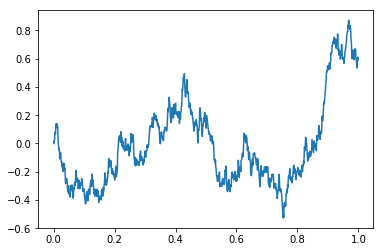

In [16]:
rnd.random_state(np.random.RandomState(seed=42), force=True)
em = sim.EulerMaruyama(process=X, initial_value=x0, times=sim.xtimes(start=0., stop=1., step=1E-3))
df = sim.run(em)
plt.plot(df);

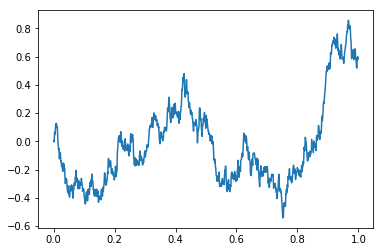

In [17]:
rnd.random_state(np.random.RandomState(seed=42), force=True)
x = [x0]
ts = [0.]; xs = [x]
for t, v in zip(sim.xtimes(0., 1., 1E-3), rnd.multivariate_normals(ndim=1)):
    x = X.propagate(ts[-1], x, t, v)
    ts.append(t); xs.append(x.flatten())
plt.plot(ts, xs);

#### Univariate variance-scaled Wiener process with drift

In [18]:
X = proc.WienerProcess(mean=3., vol=4.)
x0 = 7.

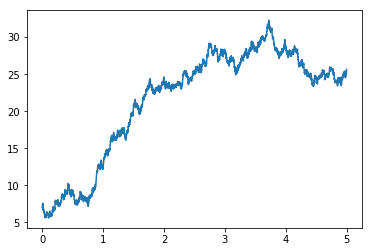

In [19]:
rnd.random_state(np.random.RandomState(seed=42), force=True)
em = sim.EulerMaruyama(process=X, initial_value=x0, times=sim.xtimes(start=0., stop=5., step=1E-3))
df = sim.run(em)
plt.plot(df);

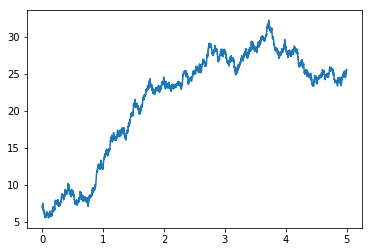

In [20]:
rnd.random_state(np.random.RandomState(seed=42), force=True)
x = [x0]
ts = [0.]; xs = [x]
for t, v in zip(sim.xtimes(0., 5., 1E-3), rnd.multivariate_normals(ndim=1)):
    x = X.propagate(ts[-1], x, t, v)
    ts.append(t); xs.append(x.flatten())
plt.plot(ts, xs);

#### Multivariate variance-scaled, correlated Wiener process with drift

In [21]:
X = proc.WienerProcess.create_from_cov(mean=[3., 5.], cov=[[16., -8.], [-8., 16.]])
x0 = npu.col(7., 8.)

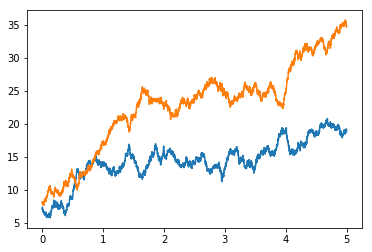

In [22]:
rnd.random_state(np.random.RandomState(seed=42), force=True)
em = sim.EulerMaruyama(process=X, initial_value=x0, times=sim.xtimes(start=0., stop=5., step=1E-3))
df = sim.run(em)
plt.plot(df);

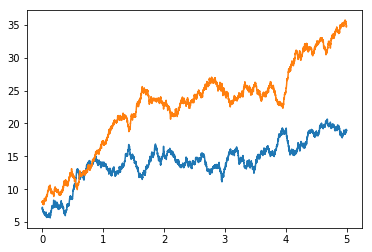

In [23]:
rnd.random_state(np.random.RandomState(seed=42), force=True)
x = x0
ts = [0.]; xs = [x0.flatten()]
for t, v in zip(sim.xtimes(0., 5., 1E-3), rnd.multivariate_normals(ndim=2)):
    x = X.propagate(ts[-1], x, t, v)
    ts.append(t); xs.append(x.flatten())
plt.plot(ts, xs);

### Brownian Bridge

#### Standard Brownian bridge

In [24]:
X = proc.BrownianBridge()

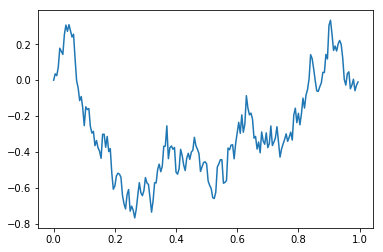

In [25]:
rnd.random_state(np.random.RandomState(seed=42), force=True);
ts = []; xs = []
for t, x in sim.EulerMaruyama(process=X, initial_value=0., times=sim.xtimes(0., 1., .005)):
    ts.append(t); xs.append(x.flatten())
plt.plot(ts, xs);

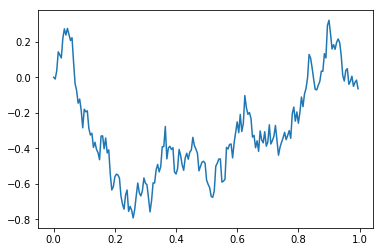

In [26]:
rnd.random_state(np.random.RandomState(seed=42), force=True);
x = [0.]
ts = [0.]; xs = [x]
for t, v in zip(sim.xtimes(0., 1., .005), rnd.multivariate_normals(ndim=1)):
    x = X.propagate(ts[-1], x, t, v)
    ts.append(t); xs.append(x.flatten())
plt.plot(ts, xs);

#### Generalised Brownian bridge

In [27]:
X = proc.BrownianBridge(10., 15., 0., 10.)

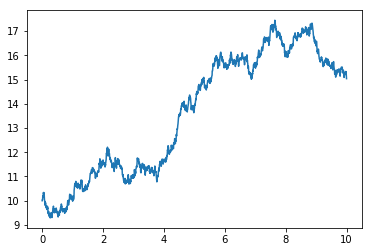

In [28]:
rnd.random_state(np.random.RandomState(seed=42), force=True);
ts = []; xs = []
for t, x in sim.EulerMaruyama(process=X, initial_value=10., times=sim.xtimes(0., 10., .005)):
    ts.append(t); xs.append(x.flatten())
plt.plot(ts, xs);

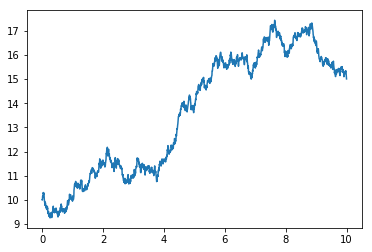

In [29]:
rnd.random_state(np.random.RandomState(seed=42), force=True);
x = [10.]
ts = [0.]; xs = [x]
for t, v in zip(sim.xtimes(0., 10., .005), rnd.multivariate_normals(ndim=1)):
    x = X.propagate(ts[-1], x, t, v)
    ts.append(t); xs.append(x.flatten())
plt.plot(ts, xs);

#### Multivariate Brownian bridge

In [30]:
x0 = npu.col(10., 7.)
cov = [[1., -2.], [-2., 9.]]
X = proc.BrownianBridge.create_from_cov(x0, npu.col(15., 3.), 0., 10., cov)

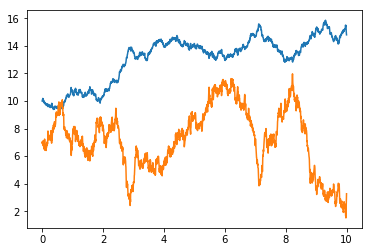

In [31]:
rnd.random_state(np.random.RandomState(seed=42), force=True);
ts = []; xs = []
for t, x in sim.EulerMaruyama(process=X, initial_value=x0, times=sim.xtimes(0., 10., .005)):
    ts.append(t); xs.append(x.flatten())
plt.plot(ts, xs);

In [32]:
xs[-1]

array([14.80169936,  3.26799591])

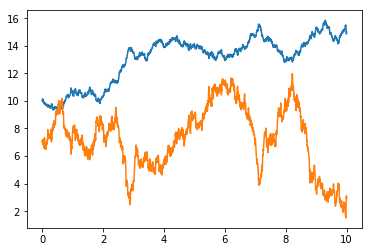

In [33]:
rnd.random_state(np.random.RandomState(seed=42), force=True)
x = x0
ts = [0.]; xs = [x0.flatten()]
for t, v in zip(sim.xtimes(0., 10., .005), rnd.multivariate_normals(ndim=2)):
    x = X.propagate(ts[-1], x, t, v)
    ts.append(t); xs.append(x.flatten())
plt.plot(ts, xs);

In [34]:
xs[-1]

array([15.00869365,  2.93182848])

#### A more efficient method for simulating a Brownian bridge

In [35]:
start_time = 0.
end_time = 10.
times = np.linspace(0., 10., 1000)
start_value = 10.
end_value = 15.

In [36]:
times_col = npu.to_ndim_2(times, ndim_1_to_col=True)

In [37]:
mean = start_value + (times_col - start_time) / (end_time - start_time) * (end_value - start_value)

In [38]:
cov = np.array([[(end_time - max(times[i], times[j])) * (min(times[i], times[j]) - start_time) / (end_time - start_time) for j in range(len(times))] for i in range(len(times))])

In [39]:
values = rnd.multivariate_normal(mean, cov)

In [40]:
all_times = np.concatenate(([start_time], times, [end_time]))

In [41]:
all_values = np.concatenate(([start_value], values, [end_value]))

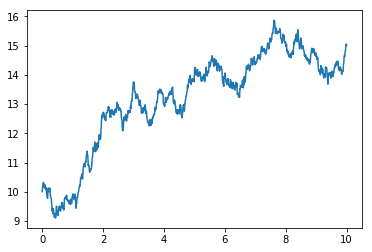

In [42]:
plt.plot(all_times, all_values);

### Geometric Brownian motion

#### Univariate geometric Brownian motion

In [43]:
X = proc.GeometricBrownianMotion()
x0 = .3

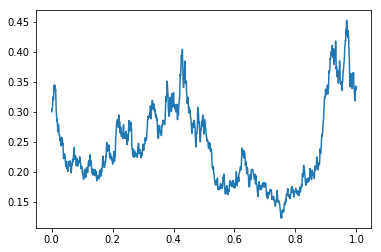

In [44]:
rnd.random_state(np.random.RandomState(seed=42), force=True)
em = sim.EulerMaruyama(process=X, initial_value=x0, times=sim.xtimes(start=0., stop=1., step=1E-3))
df = sim.run(em)
plt.plot(df);

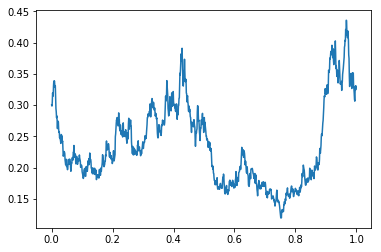

In [45]:
rnd.random_state(np.random.RandomState(seed=42), force=True)
x = [x0]
ts = [0.]; xs = [x]
for t, v in zip(sim.xtimes(0., 1., 1E-3), rnd.multivariate_normals(ndim=1)):
    x = X.propagate(ts[-1], x, t, v)
    ts.append(t); xs.append(x.flatten())
plt.plot(ts, xs);

In [46]:
X = proc.WienerProcess()
x0 = .3

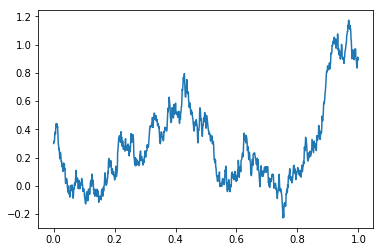

In [47]:
rnd.random_state(np.random.RandomState(seed=42), force=True)
em = sim.EulerMaruyama(process=X, initial_value=x0, times=sim.xtimes(start=0., stop=1., step=1E-3))
df = sim.run(em)
plt.plot(df);

#### Multivariate variance-scaled, correlated geometric Brownian motion with drift

In [48]:
X = proc.GeometricBrownianMotion.create_from_pct_cov(pct_drift=[3., 5.], pct_cov=[[16., -8.], [-8., 16.]])
x0 = npu.col(7., 8.)

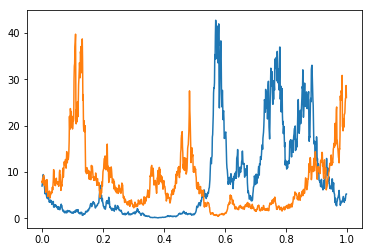

In [49]:
rnd.random_state(np.random.RandomState(seed=42), force=True)
em = sim.EulerMaruyama(process=X, initial_value=x0, times=sim.xtimes(start=0., stop=1., step=1E-3))
df = sim.run(em)
plt.plot(df);

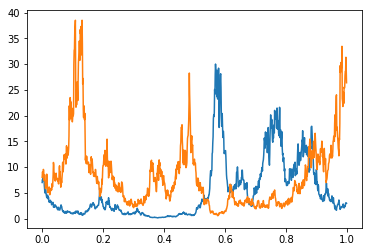

In [50]:
rnd.random_state(np.random.RandomState(seed=42), force=True)
x = x0
ts = [0.]; xs = [x0.flatten()]
for t, v in zip(sim.xtimes(0., 1., 1E-3), rnd.multivariate_normals(ndim=2)):
    x = X.propagate(ts[-1], x, t, v)
    ts.append(t); xs.append(x.flatten())
plt.plot(ts, xs);

### Ornstein-Uhlenbeck process

#### Univariate Ornstein-Uhlenbeck process

In [51]:
X = proc.OrnsteinUhlenbeckProcess(transition=1., vol=1.)
x0 = 0.

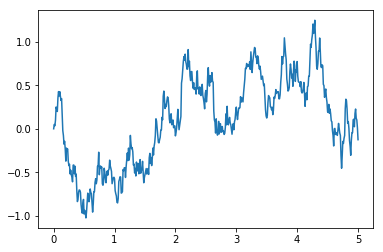

In [52]:
rnd.random_state(np.random.RandomState(seed=42), force=True)
em = sim.EulerMaruyama(process=X, initial_value=x0, times=sim.xtimes(start=0., stop=5., step=.01))
df = sim.run(em)
plt.plot(df);

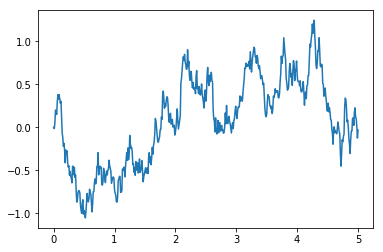

In [53]:
rnd.random_state(np.random.RandomState(seed=42), force=True)
x = [0.]
ts = [0.]; xs = [x]
for t, v in zip(sim.xtimes(0., 5., .01), rnd.multivariate_normals(ndim=1)):
    x = X.propagate(ts[-1], x, t, v)
    ts.append(t); xs.append(x.flatten())
plt.plot(ts, xs);

#### Multivariate Ornstein-Uhlenbeck process

In [54]:
X = proc.OrnsteinUhlenbeckProcess.create_from_cov(
        transition=[[10., 0.], [0., 10.]],
        mean=[3., 5.],
        cov=[[9., -7.5], [-7.5, 25.]])
x0 = npu.col(7., 8.)

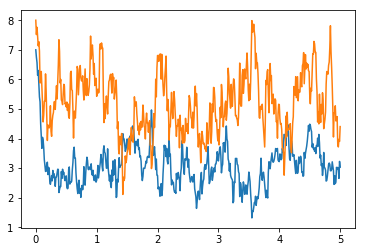

In [55]:
rnd.random_state(np.random.RandomState(seed=42), force=True)
em = sim.EulerMaruyama(process=X, initial_value=x0, times=sim.xtimes(start=0., stop=5., step=.01))
df = sim.run(em)
plt.plot(df);

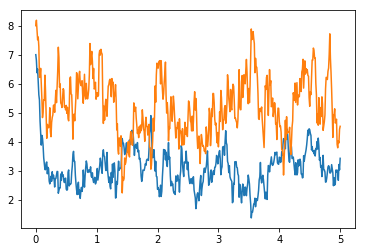

In [56]:
rnd.random_state(np.random.RandomState(seed=42), force=True)
x = x0
ts = [0.]; xs = [x0.flatten()]
for t, v in zip(sim.xtimes(0., 5., .01), rnd.multivariate_normals(ndim=2)):
    x = X.propagate(ts[-1], x, t, v)
    ts.append(t); xs.append(x.flatten())
plt.plot(ts, xs);